In [1]:
# Load libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import keras
import tensorflow as tf
import PIL

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image

In [2]:
#Define paths to datasets
keypts_data_path = "../input/celeba-dataset/list_landmarks_align_celeba.csv"
images_data_path = "../input/celeba-dataset/img_align_celeba/img_align_celeba"

#Select only 1k images first
img_data_size = 35000

#Original image dimensions
x_og = 178
y_og = 218

# New image dimensions
x_ = 45   
image_size_ratio = x_og / y_og
y_ = int(image_size_ratio * x_)

# Image Sizes
original_image_size = (x_og, y_og)
new_image_size = (x_,y_)

# The image size that will be used in the training process
image_size_training = new_image_size

### Loading dataset of the facial keypoints

In [3]:
keypts_og = pd.read_csv(keypts_data_path)[:img_data_size]
keypts_og.sample(5)

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
3764,003765.jpg,70,111,108,111,87,135,73,152,104,152
14179,014180.jpg,70,111,107,111,90,137,74,152,104,153
28702,028703.jpg,70,110,106,111,88,137,74,153,103,153
9264,009265.jpg,68,111,108,113,80,139,69,150,110,152
2434,002435.jpg,67,112,110,113,88,133,69,149,109,151


In [4]:
keypts_og.describe()

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
count,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000
mean,69.368743,111.189143,107.625971,111.153229,88.030029,135.075829,71.282286,152.119200,105.553571,152.215571
std,1.717107,1.128984,1.685886,1.178651,6.702350,4.264796,3.171467,1.795088,3.241235,1.736808
min,60.000000,99.000000,90.000000,99.000000,59.000000,102.000000,60.000000,142.000000,90.000000,139.000000
25%,68.000000,111.000000,107.000000,111.000000,84.000000,133.000000,69.000000,151.000000,103.000000,151.000000
50%,69.000000,111.000000,108.000000,111.000000,88.000000,135.000000,72.000000,152.000000,105.000000,152.000000
75%,70.000000,112.000000,109.000000,112.000000,92.000000,138.000000,74.000000,153.000000,108.000000,153.000000
max,85.000000,121.000000,121.000000,120.000000,120.000000,154.000000,88.000000,168.000000,119.000000,170.000000


In [5]:
keypts_og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_id      35000 non-null  object
 1   lefteye_x     35000 non-null  int64 
 2   lefteye_y     35000 non-null  int64 
 3   righteye_x    35000 non-null  int64 
 4   righteye_y    35000 non-null  int64 
 5   nose_x        35000 non-null  int64 
 6   nose_y        35000 non-null  int64 
 7   leftmouth_x   35000 non-null  int64 
 8   leftmouth_y   35000 non-null  int64 
 9   rightmouth_x  35000 non-null  int64 
 10  rightmouth_y  35000 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 2.9+ MB


In [6]:
keypts_og.shape

(35000, 11)

### Looking into the coordinates

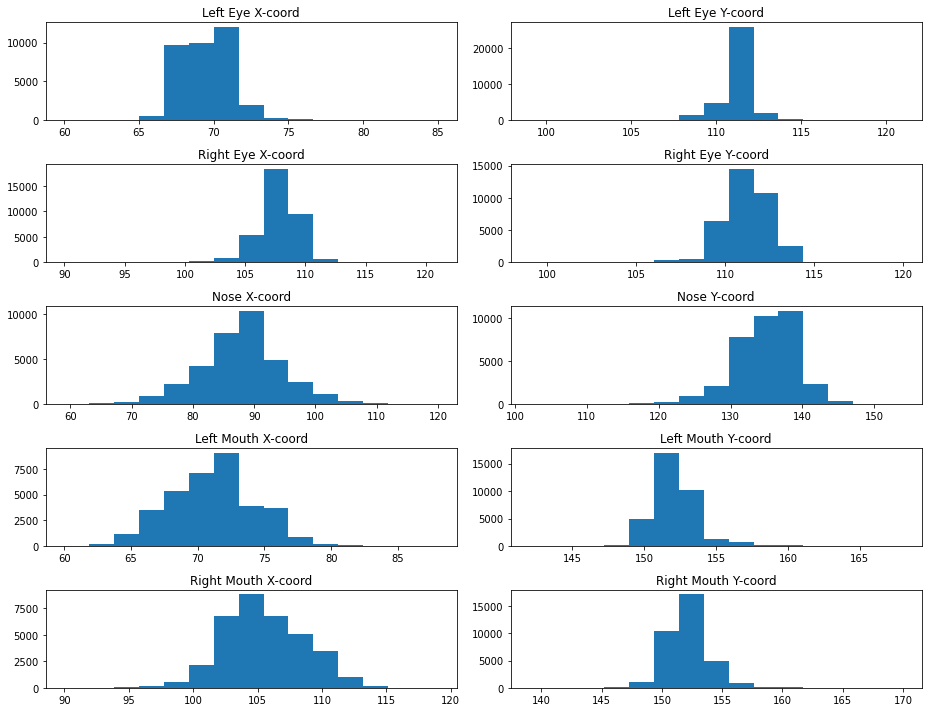

In [27]:
#Plotting distribution of the keypoints' coordinates
fig, axs = plt.subplots(5, 2, figsize=(13,10))

axs[0,0].hist(keypts_og.lefteye_x, bins=15)
axs[0,0].set_title('Left Eye X-coord')
axs[0,1].hist(keypts_og.lefteye_y, bins=15)
axs[0,1].set_title('Left Eye Y-coord')

axs[1,0].hist(keypts_og.righteye_x, bins=15)
axs[1,0].set_title('Right Eye X-coord')
axs[1,1].hist(keypts_og.righteye_y, bins=15)
axs[1,1].set_title('Right Eye Y-coord')

axs[2,0].hist(keypts_og.nose_x, bins=15)
axs[2,0].set_title('Nose X-coord')
axs[2,1].hist(keypts_og.nose_y, bins=15)
axs[2,1].set_title('Nose Y-coord')

axs[3,0].hist(keypts_og.leftmouth_x, bins=15)
axs[3,0].set_title('Left Mouth X-coord')
axs[3,1].hist(keypts_og.leftmouth_y, bins=15)
axs[3,1].set_title('Left Mouth Y-coord')

axs[4,0].hist(keypts_og.rightmouth_x, bins=15)
axs[4,0].set_title('Right Mouth X-coord')
axs[4,1].hist(keypts_og.rightmouth_y, bins=15)
axs[4,1].set_title('Right Mouth Y-coord')

plt.tight_layout()
plt.show()

### Images into an array

In [7]:
images = []

for idx in range(keypts_og.shape[0]):
    #Retrieve path
    path = "{}/{}".format(str(images_data_path), str(keypts_og.iloc[idx].image_id))
    
    #Reading images
    image = PIL.Image.open(path).resize(image_size_training)
    image_array = np.asarray(image) / 255
    
    #Append images
    images.append(image_array)

KeyboardInterrupt: 

In [ ]:
#Convert to array
images = np.array(images)

images.shape

### Sample image

In [ ]:
#Plotting sample images
fig, axs = plt.subplots(2, 2)
axs[0,0].imshow(images[400])
axs[1,0].imshow(images[1900])
axs[1,1].imshow(images[2500])
axs[0,1].imshow(images[700])
plt.show()

### Helper Functions

In [ ]:
#Read image based on index
def imread_index(index, size=image_size_training, path=images_data_path):
    """This function helps read images based on the its index by converting it to an array.
    """
    path = "{}/{}".format(str(path), str(keypts_og.iloc[index].image_id))
    
    #read the image
    image = PIL.Image.open(path).resize(size)
    image_array = np.asarray(image)
    
    return image_array

In [ ]:
#Get a list of all key points of the face
def img_keypts_list(index, df=keypts_og):
    """ This function returns a list of all the key points of the face image so 
    it's easier to plot
    """
    points_list = [df.iloc[index].lefteye_x, df.iloc[index].lefteye_y,
                  df.iloc[index].righteye_x, df.iloc[index].righteye_y,
                  df.iloc[index].nose_x, df.iloc[index].nose_y,
                  df.iloc[index].leftmouth_x, df.iloc[index].leftmouth_y,
                  df.iloc[index].rightmouth_x, df.iloc[index].rightmouth_y]
    
    return points_list

In [ ]:
#Plot image with green bounding box and keypoints
def plot_face_bbox(index, df=keypts_og, size=original_image_size):
    """ This function plots the face image with its keypoints and bounding box
    """
    img = imread_index(index, size)
    points_list = img_keypts_list(index, df)
    
    #Plotting the image
    fig, ax = plt.subplots()
    ax.imshow(img)
    
    #Plot the face points
    ax.plot(points_list[::2], points_list[1::2], 'bo-')
    
    #Plot bounding box
    width = abs(points_list[0] - points_list[8] - 60) #obtain width from left eye x to right mouth x
    height = abs(points_list[1] - points_list[9] - 75)#obtain width from left eye y to right mouth y
    rect = patches.Rectangle((points_list[0]-30, points_list[1]-40), width, height, linewidth=4, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    
    #Remove axis
    plt.axis('off')
    plt.show()

In [ ]:
#test
idx1, idx2, idx3 = np.random.randint(0, 35000, size=3)

#Test plotting sample images
plot_face_bbox(idx1)
plot_face_bbox(idx2)
plot_face_bbox(idx3)

Since the image sizes were scaled down, the key points also need to be rescaled.

In [ ]:
#Copy the original dataframe to leave it intact
keypts = keypts_og.copy()

x_old, y_old = original_image_size
x_new, y_new = image_size_training

#Get ratio of new to old for rescaling
x_ratio = x_new / x_old
y_ratio = y_new / y_old

keypts_x = ['lefteye_x', 'righteye_x', 'nose_x', 'leftmouth_x', 'rightmouth_x']
keypts_y = ['lefteye_y', 'righteye_y', 'nose_y', 'leftmouth_y', 'rightmouth_y']

#Rescale the keypoints
keypts[keypts_x] = (keypts[keypts_x] * x_ratio).astype('int')
keypts[keypts_y] = (keypts[keypts_y] * y_ratio).astype('int')

In [ ]:
#Check keypoints to see if rescaled
keypts.head()

### Split data into training and test datasets

In [ ]:
# training data
train_labels = keypts[:img_data_size - 1000]
train_images = images[:img_data_size - 1000]


# test data (1000 sample)
test_labels = keypts[img_data_size - 1000 + 1:]
test_images = images[img_data_size - 1000 + 1:]

### Train and Validation Sets

In [ ]:
#Dropping image_id column
y = train_labels.drop(['image_id'], axis = 1) 
X = train_images

# check
y.head(3)

In [ ]:
#Split the data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state = 42)

#Check the ratio
X_val.shape[0]/X_train.shape[0]

### Building and Training the Model

In [ ]:
#Img dimensions
x_ = image_size_training[0]
y_ = image_size_training[1]

#Building the model
model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu', input_shape=(y_, x_, 3)))
model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='relu'))

In [ ]:
model.summary()

In [ ]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
#Fit model 
training_process = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val), batch_size=300, shuffle=True)

### Testing the Model

In [ ]:
# function to plot the image with green box around the faces
def plot_test_img(index, pred_or_actual = 'pred', pointsColor='ro-', boxcolor='g'):
    img = tf.keras.preprocessing.image.load_img("{}/0{}.jpg".format(images_data_path, index),target_size=(y_og,x_og,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    test_image = img/255
    
    #Obtain predictions for key points of face
    if pred_or_actual == 'pred':
        img = tf.keras.preprocessing.image.load_img("{}/0{}.jpg".format(images_data_path, index),target_size=(y_,x_,3))
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img/255
        
        points_list = model.predict(img.reshape(1,y_,x_,3)).astype('int')[0]
        
        #convert key pts values to original size
        x_ratio = 1.05 * (original_image_size[0] / image_size_training[0])
        y_ratio = 1.085 * (original_image_size[1] / image_size_training[1])
        
        points_list[0] = int(points_list[0] * x_ratio)
        points_list[2] = int(points_list[2] * x_ratio)
        points_list[4] = int(points_list[4] * x_ratio)
        points_list[6] = int(points_list[6] * x_ratio)
        points_list[8] = int(points_list[8] * x_ratio)
    
        points_list[1] = int(points_list[1] * y_ratio)
        points_list[3] = int(points_list[3] * y_ratio)
        points_list[5] = int(points_list[5] * y_ratio)
        points_list[7] = int(points_list[7] * y_ratio)
        points_list[9] = int(points_list[9] * y_ratio)
        
    elif pred_or_actual == 'actual':      
        points_list = img_keypts_list(index)
        pointsColor = 'bo-'
    
    # face points
    le_x, le_y, re_x, re_y = points_list[0], points_list[1], points_list[2], points_list[3]
    n_x, n_y = points_list[4], points_list[5]
    lm_x, lm_y, rm_x, rm_y = points_list[6], points_list[7], points_list[8], points_list[9]

    # Create figure and axes
    fig, ax = plt.subplots()
    # plot the image
    ax.imshow(test_image)
    # plot the points on the face
    ax.plot([le_x,re_x,n_x,lm_x,rm_x], [le_y,re_y,n_y,lm_y,rm_y], pointsColor)
    
    # plot the box around the face
    width = abs(le_x-rm_x-60)
    height = abs(le_y-rm_y-75)
    rect = patches.Rectangle((le_x-30, le_y-40), width, height, linewidth=4, edgecolor=boxcolor, facecolor='none')
    ax.add_patch(rect);
    return points_list

In [ ]:
index = 34100
plot_test_img(index, pred_or_actual = 'pred')
plot_test_img(index, pred_or_actual='actual')

In [ ]:
# losses of both training and validation sets
loss = training_process.history['loss']
val_loss = training_process.history['val_loss']

# plot both losses
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss']);

In [ ]:
# saving the model as h5 file
model.save('model.h5')